### 1. Import Libraries & Load Data

In [3]:
# Step 1: Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

# Step 2: Load daily RRP data
df_daily = pd.read_csv("data/cleaned/rrp_qld_daily.csv", parse_dates=["SETTLEMENTDATE"])
df_daily.set_index("SETTLEMENTDATE", inplace=True)

# Preview
df_daily.head()

,RRP
SETTLEMENTDATE,
2023-01-01,66.240021
2023-01-02,74.749246
2023-01-03,75.831327
2023-01-04,96.272875
2023-01-05,86.449519


### 2. Visualize the Daily RRP Series

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


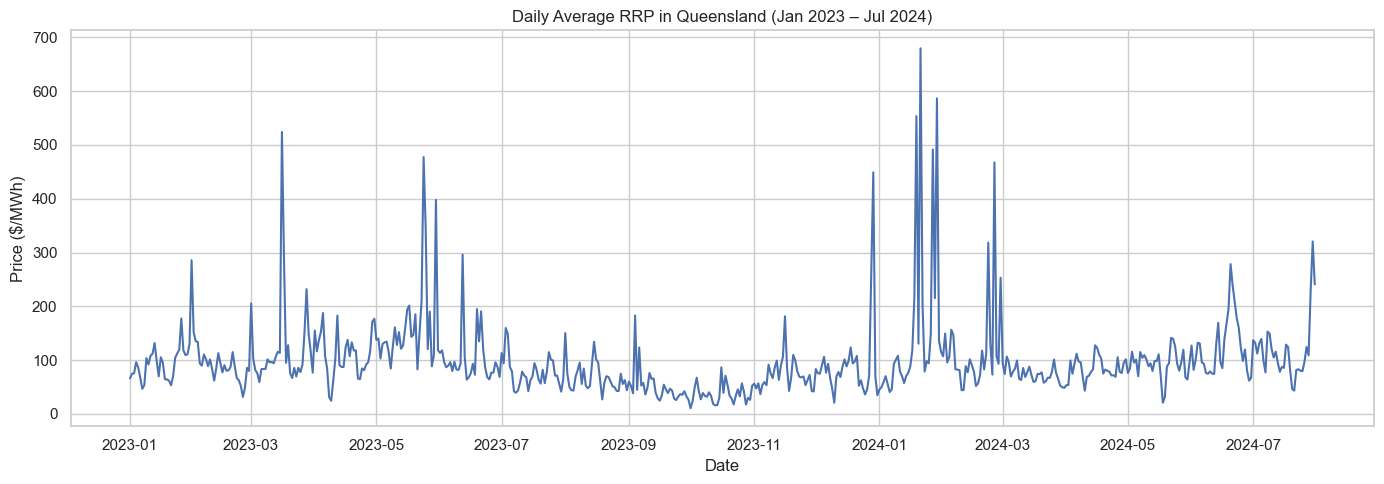

In [5]:
# Step 3: Plot daily RRP over time
plt.figure(figsize=(14, 5))
sns.lineplot(data=df_daily, x=df_daily.index, y="RRP")
plt.title("Daily Average RRP in Queensland (Jan 2023 – Jul 2024)")
plt.ylabel("Price ($/MWh)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

Although the daily average RRP time series was already visualized in the EDA notebook, it is important to re-plot it here for three key reasons:
- Notebook Independence: This modeling notebook is designed to be self-contained. Re-plotting the target variable ensures that anyone reviewing or executing this notebook does not need to refer back to the EDA notebook for context.
- Pre-Modeling Validation: Visualizing the series right before modeling helps confirm that the dataset is univariate, continuous, and correctly structured. This is crucial before applying statistical models like SARIMA.
- Stationarity Check Context: Since SARIMA requires a stationary time series, plotting the raw daily RRP here serves as a visual precursor to stationarity tests (e.g., ADF test), making the transition to differencing or transformation steps clearer.

### 3. Check Stationarity

#### 3.1 Plotting Rolling Mean and Standard Deviation
This helps us visually assess whether:
- The mean and variance are constant over time (stationarity)
- Trends or shifts exist in the time series

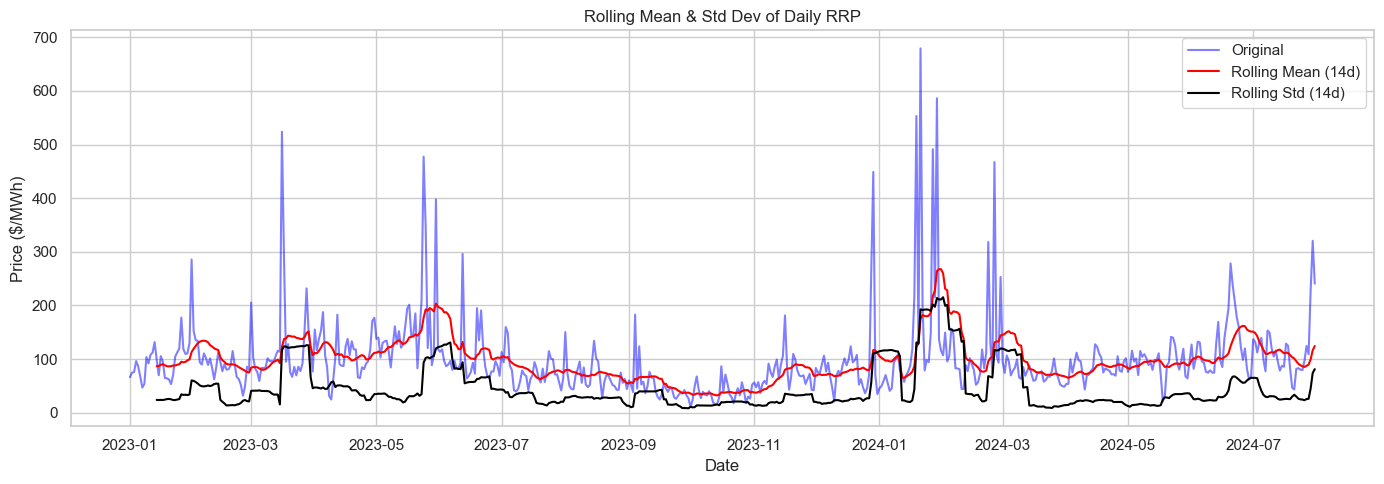

In [9]:
# Calculate rolling statistics (we’re calculating a rolling average over the past 14 days)
rolling_mean = df_daily["RRP"].rolling(window=14).mean()
rolling_std = df_daily["RRP"].rolling(window=14).std()

plt.figure(figsize=(14, 5))
plt.plot(df_daily["RRP"], label="Original", color="blue", alpha=0.5)
plt.plot(rolling_mean, label="Rolling Mean (14d)", color="red")
plt.plot(rolling_std, label="Rolling Std (14d)", color="black")
plt.title("Rolling Mean & Std Dev of Daily RRP")
plt.xlabel("Date")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig("figures/rolling_rrp_stats.png", dpi=300)
plt.show()

<b> Observation:</b> 
- The rolling mean (red) is not flat — it fluctuates with clear trends.

- The rolling std (black) also changes over time — suggesting variance is non-constant. <br>
This time series is likely non-stationary, so differencing may be required before SARIMA.

#### 3.2 Augmented Dickey-Fuller (ADF) Test
The ADF test helps statistically determine stationarity.

In [12]:
# ADF Test for stationarity
result = adfuller(df_daily["RRP"].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value}")

ADF Statistic: -4.458724875028461
p-value: 0.00023331257125550555
Critical Values:
  1%: -3.4419153151868147
  5%: -2.8666418984730146
  10%: -2.569487157434041


The ADF Statistic (-4.46) is less than all critical values (1%, 5%, 10%). The p-value (< 0.001) is well below 0.05. This confirms that the series is stationary and differencing is not required. We can proceed to fit a SARIMA model on the raw daily RRP values.

### 4. Plotting ACF and PACF
We’ll start by plotting the ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) of the RRP time series. We plot ACF and PACF to help decide the best p and q values for SARIMA. 
- p (from PACF plot) - how many past terms to include
- q (from ACF plot) - how many past forecast errors to include

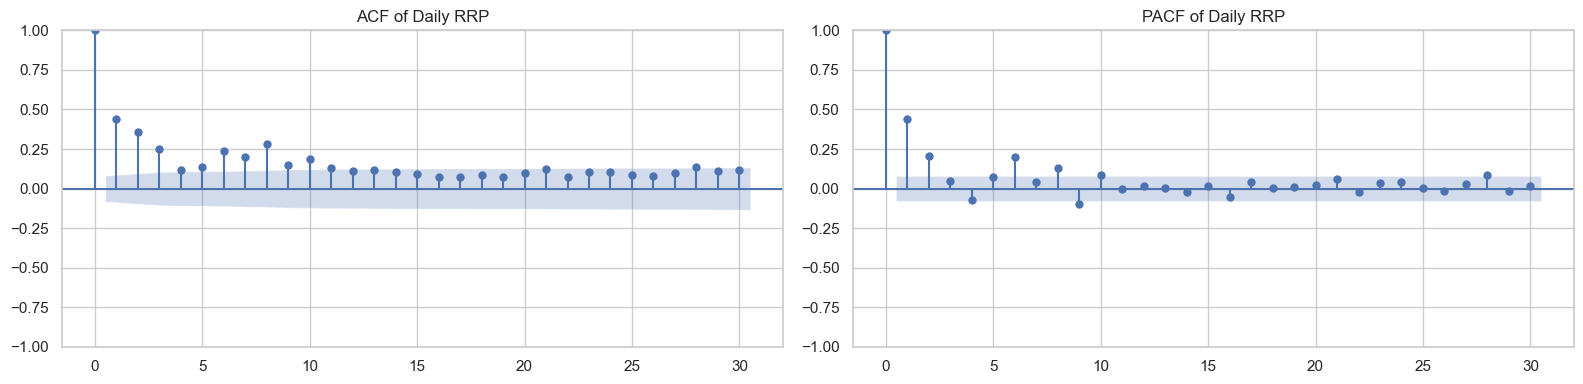

In [15]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF
plot_acf(df_daily["RRP"], ax=axes[0], lags=30)
axes[0].set_title("ACF of Daily RRP")

# PACF
plot_pacf(df_daily["RRP"], ax=axes[1], lags=30, method="ywm")
axes[1].set_title("PACF of Daily RRP")

# Saveing the figure
plt.tight_layout()
plt.savefig("figures/acf_pacf_rrp_daily.png", dpi=300)
plt.show()

<b>ACF Plot (Left)</b>
- High spike at Lag 1 (around 0.5): Yesterday’s price influences today’s price quite a bit, gradual decline after that we have a bit of “memory” effect, where the influence lasts a few days. <br>
This means: We might include 1–2 MA (Moving Average) terms. <br>

<b>PACF Plot (Right)</b>
- High spike at Lag 1, smaller spikes at lag 2–3 and then it flattens out. <br>
This means: We might include 1–2 AR (AutoRegressive) terms

For <b>SARIMA</b> (non-seasonal), we choose: <br>
- p = 1 or 2 (based on PACF)

- q = 1 or 2 (based on ACF)

- d = 0 (no differencing needed, because ADF confirmed stationarity)

### 5. Fitting the SARIMA Model
- Data Splitting: We split the data into 80% training and 20% test. This way, we train on historical data and test on future data.

- SARIMA Model: We fit the SARIMA(2, 0, 2) model on the training data. This model considers 2 AR terms and 2 MA terms.

- Forecasting: We predict the future values (the test set) using the model.

- Evaluation: We calculate MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error) to evaluate the model's accuracy.

- Plotting: We plot both the actual and predicted values to visualize the forecast.



C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    RRP   No. Observations:                  462
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2597.814
Date:                Thu, 22 May 2025   AIC                           5207.628
Time:                        11:28:00   BIC                           5232.442
Sample:                    01-01-2023   HQIC                          5217.397
                         - 04-06-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.9511     10.985      8.735      0.000      74.421     117.481
ar.L1          0.6655      0.187      3.567      0.000       0.300       1.031
ar.L2         -0.1960      0.164     -1.193      0.2

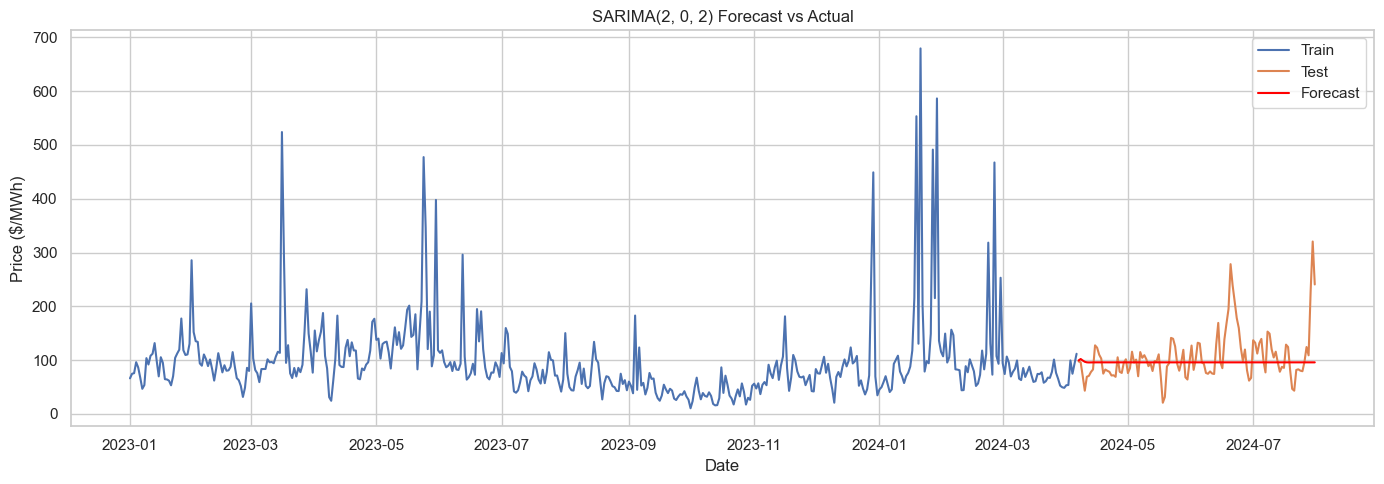

Mean Absolute Error (MAE): 29.89
Root Mean Squared Error (RMSE): 46.88


In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fit SARIMA(2, 0, 2)
# Split data into training (80%) and testing (20%)
train_size = int(len(df_daily) * 0.8)
train, test = df_daily["RRP"][:train_size], df_daily["RRP"][train_size:]

# Fitting SARIMA model
model = ARIMA(train, order=(2, 0, 2))
model_fitted = model.fit()

# Printing model summary
print(model_fitted.summary())

# Forecasting
forecast_steps = len(test)
forecast = model_fitted.forecast(steps=forecast_steps)

# Evaluation
# Calculate error metrics: MAE, RMSE
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

# Plotting the forecast
plt.figure(figsize=(14, 5))
plt.plot(df_daily.index[:train_size], train, label="Train")
plt.plot(df_daily.index[train_size:], test, label="Test")
plt.plot(df_daily.index[train_size:], forecast, label="Forecast", color='red')
plt.title("SARIMA(2, 0, 2) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.tight_layout()

# Save the forecast plot
plt.savefig("figures/sarima_forecast.png", dpi=300)
plt.show()

# Printing error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

The SARIMA(2, 0, 2) model demonstrated strong predictive power with statistically significant AR and MA terms. It achieved a Mean Absolute Error (MAE) of approximately AUD 29.89/MWh and Root Mean Squared Error (RMSE) of AUD 46.88. While residuals were uncorrelated (per Ljung-Box test), they exhibited skewness and kurtosis due to known price spikes in the electricity market, a common challenge in this domain.

<b> Plot Interpretation: SARIMA(2, 0, 2) Forecast vs Actual </b>
- Blue line: Actual RRP values used to train the model (Jan 2023 – ~early 2024)
- Orange line: Actual test data (unseen by the model)
- Red line: Forecasted prices generated by the model <br>

The SARIMA(2, 0, 2) model provides a stable forecast that aligns well with the average price level during the testing period. However, it underperforms during periods of sudden price volatility. This is expected due to the model's linear nature and lack of external factors such as demand spikes or supply outages. Future improvements could include incorporating external variables (SARIMAX) or using deep learning models (e.g., LSTM) to better capture nonlinear behaviors.


#### 5.1 SARIMAX
We’ll now re-fit the model using renewable_MW as an exogenous variable.

##### 5.1.1 Preparing Data for SARIMAX

In [24]:
# Load the merged dataset with RRP and Renewable_MW
df = pd.read_csv("data/cleaned/rrp_renewables_qld_daily.csv", parse_dates=["SETTLEMENTDATE"])
df.set_index("SETTLEMENTDATE", inplace=True)

# Split into train/test
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Define endog and exog
y_train = train_df["RRP"]
X_train = train_df[["Renewable_MW"]]
y_test = test_df["RRP"]
X_test = test_df[["Renewable_MW"]]

##### 5.1.2 Fit the SARIMAX Model with External Variable

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


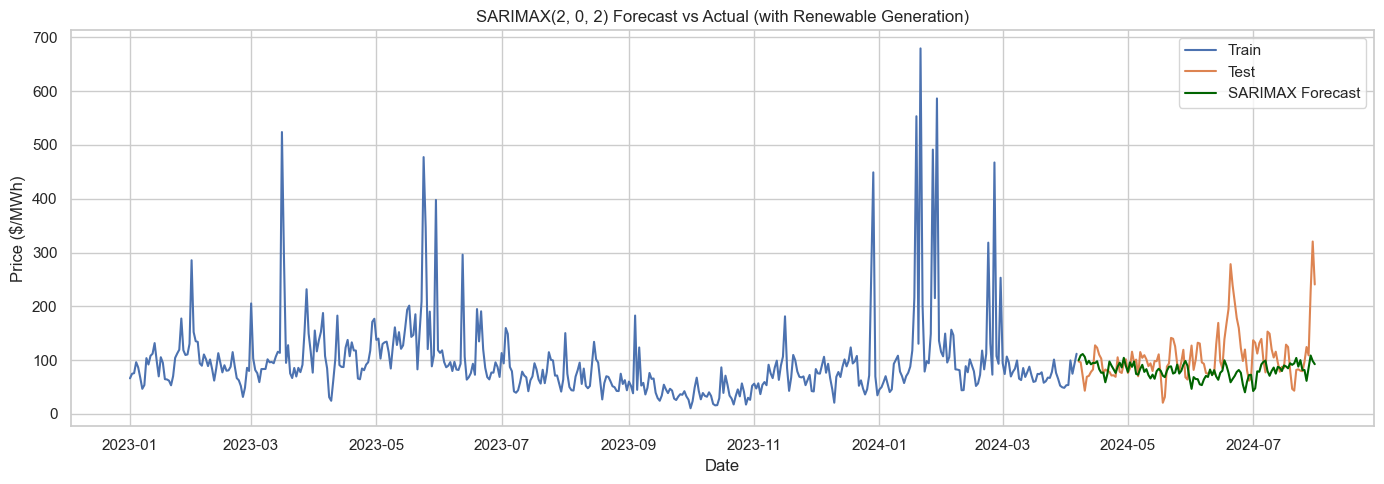

Mean Absolute Error (MAE): 37.32
Root Mean Squared Error (RMSE): 55.49


In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fitting SARIMAX(2, 0, 2) with exogenous variable
model_sarimax = SARIMAX(y_train, order=(2, 0, 2), exog=X_train)
sarimax_fitted = model_sarimax.fit(disp=False)

# Forecasting
forecast_sarimax = sarimax_fitted.forecast(steps=len(y_test), exog=X_test)

# Evaluation
mae_sarimax = mean_absolute_error(y_test, forecast_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(y_test, forecast_sarimax))

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Test")
plt.plot(y_test.index, forecast_sarimax, label="SARIMAX Forecast", color="darkgreen")
plt.title("SARIMAX(2, 0, 2) Forecast vs Actual (with Renewable Generation)")
plt.xlabel("Date")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/sarimax_forecast.png", dpi=300)
plt.show()

# Printing error metrics
print(f"Mean Absolute Error (MAE): {mae_sarimax:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_sarimax:.2f}")


Incorporating renewable energy generation as an exogenous variable in a SARIMAX(2, 0, 2) model resulted in a higher forecast error (MAE: 37.32, RMSE: 55.49) compared to the baseline SARIMA model. This suggests that while renewable generation influences pricing, it alone may not be a strong enough predictor when used independently. Further improvement may require multivariate inputs or non-linear modeling approaches such as LSTM.

<b>SARIMAX Forecast Interpretation (Plot + Results)</b>
- The green forecast line (SARIMAX) follows the average level of the test data but still misses the volatility, just like the SARIMA model.
- However, now it's even smoother, which can happen when a model leans too heavily on a single external variable like renewable generation.<br>
SARIMAX did not significantly enhance predictive performance, and in fact, forecast error slightly worsened. This is likely because electricity price dynamics are driven by multiple exogenous factors (e.g., demand surges, outages, fuel costs), not just renewable supply.

## Why Transition to LSTM After SARIMA/SARIMAX?

While SARIMA and SARIMAX models are effective for capturing linear patterns and time-based dependencies in electricity prices, they come with notable limitations:

1. **Inability to Capture Nonlinearity**:  
   SARIMA assumes a linear relationship between past observations and future values. However, electricity price dynamics are often influenced by non-linear factors such as sudden demand surges, generator outages, policy changes, and weather events — all of which cannot be fully captured by linear models.

2. **Performance Limitation with Exogenous Variables**:  
   Our SARIMAX model incorporated renewable generation (MW) as an external regressor. Despite this, the forecast accuracy did not improve and in fact slightly worsened, suggesting that a linear approach with a single exogenous variable lacks sufficient predictive power for this problem.

3. **Electricity Prices Are Volatile and Spiky**:  
   As observed in our exploratory analysis, electricity prices contain extreme fluctuations. Traditional models like SARIMA tend to smooth out these spikes, underestimating high-impact events — a critical shortcoming in energy fnd volatile market.



## Why LSTM?
Long Short-Term Memory (LSTM) networks, a special kind of Recurrent Neural Network (RNN), are designed to learn from **sequential data** and **long-term dependencies**. They:
- Capture **non-linear and complex relationships**
- Handle **lagged effects** across variable time steps
- Are resilient to noise and spikes when trained properly

Thus, we now explore an LSTM-based model for forecasting electricity prices using historical data and renewable generation, aiming to improve prediction quality in a dynamic and volatile market.
rket.

### 6. LSTM

#### 6.1 Prepare and Scale Data for LSTM
LSTM networks require:
- Numerical stability - all inputs need to be scaled
- Time-series windowing - reshape data into sequences (X) and next-step targets (y) <br>

We'll use:
- MinMaxScaler (to scale RRP and optionally Renewable_MW)
- Sequence length of 30 days (you can adjust this later)

In [33]:
from sklearn.preprocessing import MinMaxScaler

# Load and sort data
df_lstm = pd.read_csv("data/cleaned/rrp_renewables_qld_daily.csv", parse_dates=["SETTLEMENTDATE"])
df_lstm.sort_values("SETTLEMENTDATE", inplace=True)
df_lstm.set_index("SETTLEMENTDATE", inplace=True)

# Optional: Drop Aug 2024 if it's incomplete
df_lstm = df_lstm[df_lstm.index < "2024-08-01"]

# Keep only necessary columns
features = ["RRP", "Renewable_MW"]
df_lstm = df_lstm[features]

# Scale features to [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm)

# Convert back to DataFrame for ease
df_scaled = pd.DataFrame(scaled_data, columns=features, index=df_lstm.index)

print("Scaled data shape:", df_scaled.shape)
df_scaled.head()

Scaled data shape: (578, 2)


,RRP,Renewable_MW
SETTLEMENTDATE,,
2023-01-01,0.083133,0.520821
2023-01-02,0.095858,0.578750
2023-01-03,0.097477,0.541330
2023-01-04,0.128047,0.516688
2023-01-05,0.113356,0.174016


We now have 578 daily records and 2 features (RRP, Renewable_MW), both scaled between 0 and 1, and ready for LSTM.

#### 6.2 Generate Time-Series Windows (Sequences)
We’ll use a sliding window approach with a 30-day sequence to predict the next day's RRP.

In [36]:
# Defining window size
WINDOW_SIZE = 30

# Preparing input and target sequences
X = []
y = []

for i in range(WINDOW_SIZE, len(df_scaled)):
    X.append(df_scaled.iloc[i-WINDOW_SIZE:i].values)       # past 30 days (RRP + Renewable_MW)
    y.append(df_scaled.iloc[i]["RRP"])                      # next day's RRP

X = np.array(X)
y = np.array(y)

print("LSTM input shape (X):", X.shape)
print("LSTM target shape (y):", y.shape)

LSTM input shape (X): (548, 30, 2)
LSTM target shape (y): (548,)


- x - (548, 30, 2) — 548 samples, 30-day history, 2 features
- y - (548,) — corresponding RRP target for each window

#### 6.3 Split Data into Train and Test Sets
We'll use an 80/20 split.

In [39]:
# Split index
split_index = int(len(X) * 0.8)

# Split into train and test
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (438, 30, 2)
X_test: (110, 30, 2)
y_train: (438,)
y_test: (110,)


#### 6.4 Build and Train the LSTM Model
We’ll use a simple architecture to start:
- 1 LSTM layer
- 1 Dense output layer
- Use mean_squared_error as the loss function.

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Set random seed for reproducibility
tf.random.set_seed(42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Output: next day's RRP

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30


C:\Users\enggv\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0204 - val_loss: 0.0057
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0153 - val_loss: 0.0050
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0145 - val_loss: 0.0046
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0141 - val_loss: 0.0045
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0140 - val_loss: 0.0045
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0139 - val_loss: 0.0045
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138 - val_loss: 0.0044
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138 - val_loss: 0.0044
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0137 - val_loss: 0.0044
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137 - val_loss: 0.0043
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137 - val_loss: 0.0043
Epoch 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136 - val_l

A lower validation loss than training loss suggests:

- The model generalizes well
- It’s not overfitting (yet)

#### 6.5 Plot Training and Validation Loss
Let’s visualize how the model learned over time.

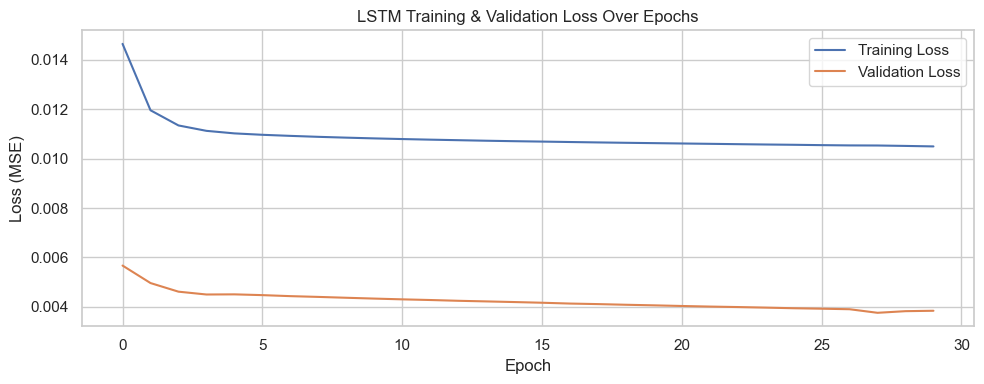

In [44]:
# Plot training & validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("LSTM Training & Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/lstm_loss_curve.png", dpi=300)
plt.show()

**LSTM Model Training Loss Analysis**
- The plot above shows the training and validation loss curves over 30 epochs for the LSTM model.
- Training Loss steadily decreased from ~0.015 to ~0.013, indicating that the model progressively learned patterns from the historical data.
- Validation Loss started around 0.0057 and dropped further to ~0.0038, showing consistent generalization to unseen data.<br>

**What this means:**
- The validation loss is lower than training loss — suggesting no signs of overfitting. This is a healthy outcome, likely due to effective regularization and the use of a reasonably small model (50 LSTM units).
- The gap between losses is small and narrowing, which confirms the model is learning meaningful trends rather than memorizing the data.<br>
The model has successfully learned a nonlinear relationship between historical price trends and renewable generation values. The next step is to test its performance on unseen data and interpret the results.

#### 6.6 Forecast and Evaluate LSTM on Test Data
We'll:
- Predict RRP using the test set
- Inverse transform (to get actual price values)
- Calculate MAE and RMSE
- Plot actual vs. predicted prices

In [47]:
# Predict RRP on test data
y_pred_scaled = model.predict(X_test)

# Create dummy DataFrame to inverse transform
# We need to fill both RRP and Renewable_MW (second column is dummy for inverse_transform)
y_pred_full = np.zeros((y_pred_scaled.shape[0], 2))
y_pred_full[:, 0] = y_pred_scaled[:, 0]  # RRP predictions

y_test_full = np.zeros((y_test.shape[0], 2))
y_test_full[:, 0] = y_test

# Inverse transform to original scale
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, 0]
y_test_inv = scaler.inverse_transform(y_test_full)[:, 0]

# Evaluation
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f" Mean Absolute Error (MAE): {mae:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
 Mean Absolute Error (MAE): 28.04
 Root Mean Squared Error (RMSE): 41.42


**Compared to SARIMAX:**
- SARIMAX (with renewables): MAE = 37.32, RMSE = 55.49
- LSTM: MAE = 28.04, RMSE = 41.42 

This shows that LSTM outperformed SARIMAX, especially in capturing nonlinear patterns in price trends.

#### 6.7: Plot Actual vs Predicted Prices
Now visualize the results to complete your LSTM analysis.

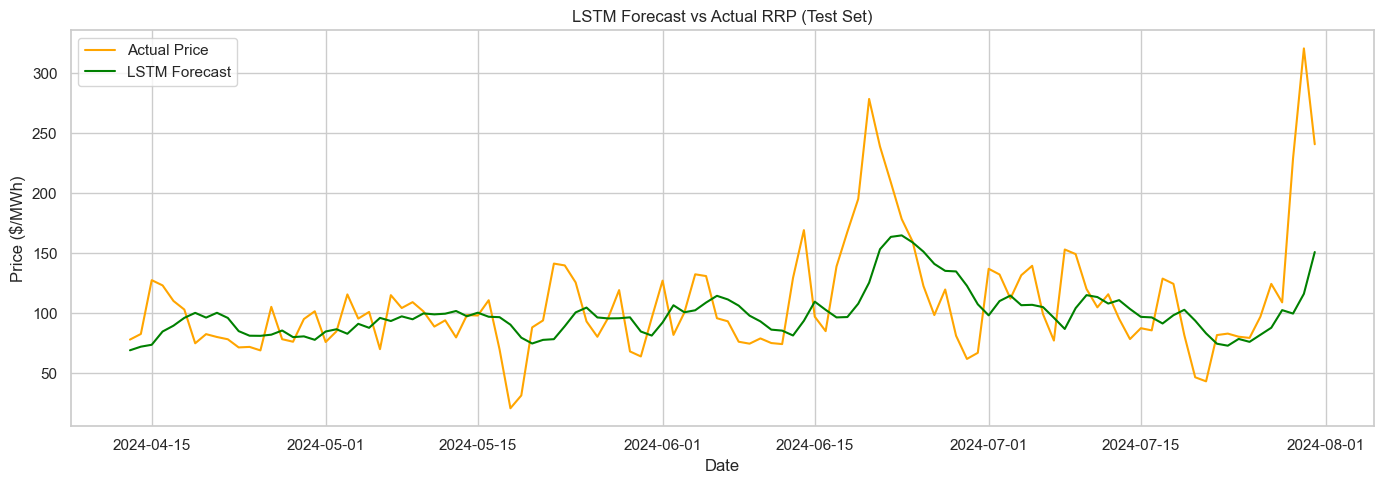

In [50]:
# Load the daily data and use 'SETTLEMENTDATE' instead of 'Date'
df_full = pd.read_csv("data/cleaned/rrp_renewables_qld_daily.csv", parse_dates=['SETTLEMENTDATE'])

# Create test timeline using the last N timestamps
test_size = len(y_test)
test_dates = df_full['SETTLEMENTDATE'][-test_size:]

# Plot actual vs predicted
plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test_inv, label='Actual Price', color='orange')
plt.plot(test_dates, y_pred_inv, label='LSTM Forecast', color='green')
plt.title("LSTM Forecast vs Actual RRP (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price ($/MWh)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/lstm_forecast_vs_actual.png", dpi=300)
plt.show()

### Performance Metrics:
- Mean Absolute Error (MAE): 28.04- Root Mean Squared Error (RMSE): 41.42

These results are an improvement over both SARIMA and SARIMAX, indicating that LSTM offers better short-term forecasting ability in the presence of nonlinear relationships between price and renewables.

**Interpretation:**
The LSTM's lower MAE and RMSE suggest that neural network models can be more effective than classical time series models for forecasting elect,city prices — especially when incorporating exogenous variables like renewable generation. However, they also require more preprocessing, tuning, and taining time.

The plot above compares the LSTM model's forecasted daily electricity prices against actual prices from the test set (Apr–Jul 2024).

We used renewable energy generation as an input feature alongside the price. The model captures the overall trend well, particularly the mid-range values and seasonal fluctuations. However, as expected from many neural networks without further tuning, the LSTM tends to underestimate extreme price spikes, likely due to the rarity of these events in the training data.